In [32]:
import sys
sys.path.append('/home/ZhiLi/CRESTHH')
from cresthh.UQ.DoE import morris_oat
from cresthh.UQ.util import scale_samples_general, read_param_file, discrepancy
from cresthh.UQ.analyze import *
# import matplotlib.pyplot as plt
sys.path.append('/home/ZhiLi/PlotGallary')
from matplotlibconfig import basic


In [2]:
pf= read_param_file('params.txt')

In [3]:
pf

{'bounds': [[0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 10.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0]],
 'names': ['friction', 'SM', 'Ksat', 'WM', 'B', 'IM', 'KE'],
 'num_vars': 7}

param_values= morris_oat.sample(10, pf['num_vars'], num_levels=10, grid_jump=1, plot=False)

param_values.shape

In [10]:
scale_samples_general(param_values, pf['bounds'])

np.savetxt('Input_params.txt', param_values, delimiter=' ')

In [7]:
outputs= np.loadtxt('Output_Sobol.txt', delimiter=',')
inputs= np.loadtxt('Input_params.txt', delimiter=' ')

In [27]:
from __future__ import division
# from ..util import read_param_file
from sys import exit
import numpy as np
from scipy.stats import norm
# import matplotlib.pyplot as plt

# Perform Morris Analysis on file of model results
def analyze(pfile, X, Y, column = 0, delim = ' ', num_resamples = 1000, plot = True, **kwargs):
    
    param_file = read_param_file(pfile)
#     Y = np.loadtxt(output_file, delimiter = delim)
#     X = np.loadtxt(input_file, delimiter = delim)

    if len(Y.shape) == 1: Y = Y.reshape((len(Y),1))
    if len(X.shape) == 1: X = X.reshape((len(X),1))
    
    if Y.ndim > 1:
        Y = Y[:, column]
    
    D = param_file['num_vars']
    
    if Y.size % (D+1) == 0:    
        N = int(Y.size / (D + 1))
    else:
        print """
                Error: Number of samples in model output file must be a multiple of (D+1), 
                where D is the number of parameters in your parameter file.
              """
        exit()            
    
    ee = np.empty([N, D])
    
    # For each of the N trajectories
    for i in range(N):
        
        # Set up the indices corresponding to this trajectory
        j = np.arange(D+1) + i*(D + 1)
        j1 = j[0:D]
        j2 = j[1:D+1]
        
        # The elementary effect is (change in output)/(change in input)
        # Each parameter has one EE per trajectory, because it is only changed once in each trajectory
        ee[i,:] = np.linalg.solve((X[j2,:] - X[j1,:]), (Y[j2] - Y[j1])) 
    
    # Output the Mu, Mu*, and Sigma Values
    mu_star_x = np.empty(0)
    sigma_y = np.empty(0)
    mu_star_conf_z=np.empty([D,num_resamples])
    print "Parameter  Mu  Sigma  Mu_Star  Mu_Star_Conf"
    for j in range(D):
        mu = np.average(ee[:,j])
        mu_star = np.average(np.abs(ee[:,j]))
        sigma = np.std(ee[:,j])
        mu_star_conf = compute_mu_star_confidence(ee[:,j], N, num_resamples)
        
        mu_star_x = np.append(mu_star_x, mu_star)
        sigma_y = np.append(sigma_y, sigma)
        mu_star_conf_z[j,:] = mu_star_conf
        
        print "%s %f %f %f %f" % (param_file['names'][j], mu, sigma, mu_star, 1.96 * mu_star_conf.std(ddof=1))
        
    if plot:
        fig=plt.figure(figsize=(15,6))
        ax1=plt.subplot(121)
        for i in range(D):
            plt.plot(mu_star_x[i], sigma_y[i], 'ro')
            plt.text(mu_star_x[i], sigma_y[i], '%s' % param_file['names'][i])
        plt.title('Morries One at A Time SA results') 
        plt.xlabel('Modified Means (of gradients)')       
        plt.ylabel('Standard Deviation (of gradients)')
        ax1=plt.subplot(122)
        mu_star_conf_z = mu_star_conf_z.T
        ax1.boxplot(mu_star_conf_z)
        ax1.set_xticks(np.arange(param_file['num_vars'])+1)
        ax1.set_xticklabels(param_file['names'])
        plt.title('Modified Means Plot(bootstrap)')
        plt.xlabel('Parameter Name')
        plt.ylabel('Modified Means (of gradients)')
        plt.show()
    
#     return mu_star_x, sigma_y, mu_star_conf_z

def compute_mu_star_confidence(ee, N, num_resamples):
   
   ee_resampled = np.empty([N])
   mu_star_resampled  = np.empty([num_resamples])
   
   for i in range(num_resamples):
       for j in range(N):
           
           index = np.random.randint(0, N)
           ee_resampled[j] = ee[index]
       
       mu_star_resampled[i] = np.average(np.abs(ee_resampled))
   
   return mu_star_resampled

Parameter  Mu  Sigma  Mu_Star  Mu_Star_Conf
friction -1.672996 3.331164 1.672996 1.246975
SM 7.273233 10.558293 7.282461 3.730545
Ksat -0.076286 0.147820 0.076286 0.053135
WM 0.048571 0.664321 0.248820 0.220656
B 1.024368 2.904323 1.024368 1.079926
IM 0.802244 0.895699 0.817126 0.308618
KE -0.003835 0.006258 0.003842 0.002232


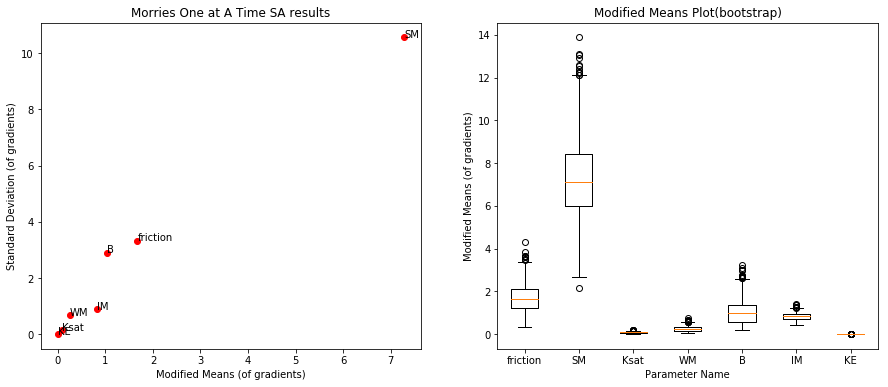

In [37]:
analyze('params.txt', inputs, outputs[1:,4],column = 0, plot=True)

In [2]:
# plt.figure(figsize=(15,10))
_fric_mu, _fric_sigma, _fric_conf= morris.analyze('params.txt', 'Input_params.txt', 'Output_Sobol.txt',column = 0, plot=False)

Parameter  Mu  Sigma  Mu_Star  Mu_Star_Conf
friction -0.057703 0.099492 0.057703 0.061775


In [3]:
mu_star_x, sigma_y, mu_star_conf_z= morris.analyze('params_expF.txt', 'Input_expF.txt', 'Output_expF.txt',column = 0, plot=False)

Parameter  Mu  Sigma  Mu_Star  Mu_Star_Conf
friction 0.000000 0.000000 0.000000 0.000000
SM 0.094048 0.032568 0.094048 0.014057
Ksat -0.000195 0.000631 0.000195 0.000272
WM -0.000213 0.000746 0.000213 0.000333
B 0.000030 0.000119 0.000030 0.000050
IM 0.000488 0.001169 0.000488 0.000509
KE -0.000179 0.000102 0.000182 0.000044


In [4]:
mu_star_x[0]= _fric_mu
sigma_y[0]= _fric_sigma
mu_star_conf_z[0]= _fric_conf

In [5]:
mu_star_conf_z.shape

(7, 1000)

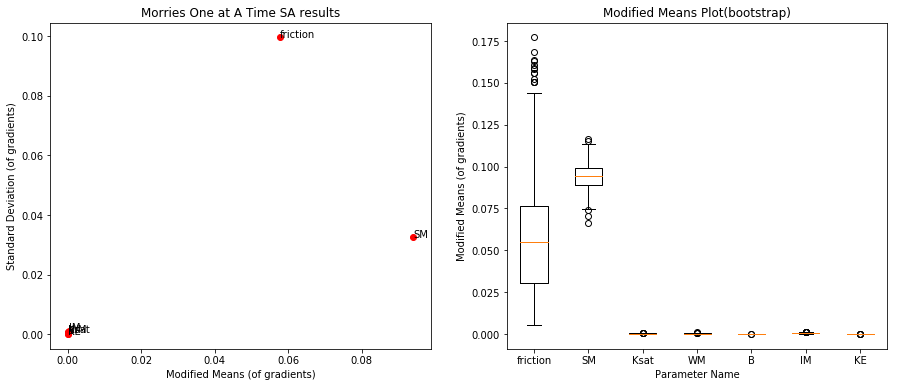

In [6]:
param_file= read_param_file('params_expF.txt')
D= len(mu_star_x)
fig=plt.figure(figsize=(15,6))
ax1=plt.subplot(121)
for i in range(D):
    plt.plot(mu_star_x[i], sigma_y[i], 'ro')
    plt.text(mu_star_x[i], sigma_y[i], '%s' % param_file['names'][i])
plt.title('Morries One at A Time SA results') 
plt.xlabel('Modified Means (of gradients)')       
plt.ylabel('Standard Deviation (of gradients)')
ax1=plt.subplot(122)
# mu_star_conf_z = mu_star_conf_z.T
ax1.boxplot([conf for conf in mu_star_conf_z])
ax1.set_xticks(np.arange(param_file['num_vars'])+1)
ax1.set_xticklabels(param_file['names'])
plt.title('Modified Means Plot(bootstrap)')
plt.xlabel('Parameter Name')
plt.ylabel('Modified Means (of gradients)')
plt.show();